In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


In [58]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

import tensorflow as tf
import numpy as np
import os
import fnmatch
import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn import manifold, datasets

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from time import time

import seaborn as sns

COMET WARNING: We detected that you are running inside a Ipython/Jupyter notebook environment but we cannot save your notebook source code. Please be sure to have installed comet_ml as a notebook server extension by running:
jupyter comet_ml enable
COMET INFO: old comet version (1.0.9) detected. current: 1.0.10 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Comet.ml support for Ipython Notebook is limited at the moment, automatic monitoring and stdout capturing is deactivated
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/incnas/general/cefbc3b7682745ff8b266b1d8e3d12be



In [4]:
from shutil import copyfile
import scipy.misc

In [39]:
sns.set(style="white")

## Load Data

In [5]:
path = "data\\sorted\\agg\\ids.csv"
root_dir = "data\\sorted\\agg\\"

In [6]:
data = pd.read_csv(path, index_col=0)

In [7]:
data = data.sample(frac=1)

In [8]:
data.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks
52,52,2017.11.17,7200,1.90 s.tifheightmap.mat,7.665951,1655,6732.873700,0.948445,1,0.757055,3.921301,[[1.71700000e+03 7.67380000e+04 4.19110800e+06...,1.495170,197.396970,[[ 47.06751865 30.20988715]\r\n [ 30.20988715...,2,1
307,194_flipped,2017.11.23,7200,19.40 s.tifheightmap.mat,14.120052,18684,133663.335573,0.896608,0,0.471640,7.153893,[[1.86840000e+04 2.59529200e+06 4.39973572e+08...,1.495617,920.607214,[[ 857.2969236 257.27820962]\r\n [ 257.27820...,0,1
185,185,2017.11.23,7200,0.20 s.tifheightmap.mat,8.050953,9880,34589.649813,0.964386,1,0.322320,3.496730,[[9.89200000e+03 1.18904900e+06 2.08831703e+08...,-1.332074,954.933116,[[ 857.1343131 -1501.72225895]\r\n [-1501.72...,2,3
146,146,2017.11.23,1800,63.190 s.tifheightmap.mat,9.263165,7400,25290.418483,0.964196,0,0.252870,3.417162,[[7.40100000e+03 1.12974800e+06 2.06903164e+08...,-1.311872,796.139177,[[ 650.68892314 -1140.5592428 ]\r\n [-1140.55...,2,2
399,97_flipped,2017.11.22,3600,14.80 s.tifheightmap.mat,5.141913,3939,9252.182630,0.939158,0,0.542562,2.348866,[[3.93900000e+03 3.03757000e+05 2.78525110e+07...,-1.481344,393.261977,[[ 141.54534772 -88.85027335]\r\n [ -88.85027...,2,1


In [56]:
samples = data.drop(columns=['name','date','source','moments','orientation','inertia_tensor'])
train_data = samples.drop(columns=['flow_rate'])

In [10]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 52 to 369
Data columns (total 9 columns):
peak_val          402 non-null float64
area              402 non-null int64
volume            402 non-null float64
eccentricity      402 non-null float64
euler_number      402 non-null int64
extent            402 non-null float64
mean_intensity    402 non-null float64
perimeter         402 non-null float64
cluster           402 non-null int64
dtypes: float64(6), int64(3)
memory usage: 31.4 KB


In [1]:
points = train_data.as_matrix()
normalized = preprocessing.Normalizer().fit_transform(points)
standardize = preprocessing.scale(points)

df_standardize = preprocessing.scale(samples.as_matrix())

NameError: name 'train_data' is not defined

In [ ]:
normalized.shape

## Data Anaylysis

## K-Means

Source: https://www.tensorflow.org/api_docs/python/tf/contrib/factorization/KMeansClustering

In [156]:
def input_fn():
    return tf.train.limit_epochs(tf.convert_to_tensor(standardize, dtype=tf.float32), num_epochs=1)

In [157]:
num_clusters = 3
kmeans = tf.contrib.factorization.KMeansClustering(num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 30
previous_centers = None

# Report hyper params:
hyper_params = {"clusters": num_clusters, "iterations": num_iterations}
experiment.log_multiple_params(hyper_params)

for _ in range(num_iterations):
    kmeans.train(input_fn)
    cluster_centers = kmeans.cluster_centers()
    if previous_centers is not None:
        print('delta:', cluster_centers - previous_centers)
    previous_centers = cluster_centers
    experiment.log_metric("score", kmeans.score(input_fn))
    print('score:', kmeans.score(input_fn))
print('cluster centers:', cluster_centers)

# map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
    cluster_index = cluster_indices[i]
    center = cluster_centers[cluster_index]
    print('point:', point, 'is in cluster', cluster_index, 'centered at', center)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Duo\\AppData\\Local\\Temp\\tmpseywr7e9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000027555FC7240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\mod

INFO:tensorflow:Starting evaluation at 2018-05-03-13:05:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-03-13:05:08
INFO:tensorflow:Saving dict for global step 7: global_step = 7, loss = 2573.1501, score = 2573.1501
score: 2573.1501
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8 into C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt.
INFO:tensorflow:loss = 2573.1501, step = 7
INFO:tensorflow:Saving checkpoin

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 16 into C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt.
INFO:tensorflow:loss = 2565.7993, step = 16
INFO:tensorflow:Saving checkpoints for 17 into C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt.
INFO:tensorflow:Loss for final step: 2565.7993.
delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-03-13:06:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-17
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done ru

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-25
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-03-13:07:38
INFO:tensorflow:Saving dict for global step 25: global_step = 25, loss = 2565.7993, score = 2565.7993
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-03-13:07:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-25
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-03-13:07:43
INFO:tensorflow:Saving dict for global step 25: global_step = 25, loss = 2565.7993, score = 2565.7993
score: 2565.7993
INFO:tensorflow:Calling

INFO:tensorflow:Finished evaluation at 2018-05-03-13:08:51
INFO:tensorflow:Saving dict for global step 33: global_step = 33, loss = 2565.7993, score = 2565.7993
score: 2565.7993
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-33
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 34 into C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt.
INFO:tensorflow:loss = 2565.7993, step = 33
INFO:tensorflow:Saving checkpoints for 35 into C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt.
INFO:tensorflow:Loss for final step: 2565.7993.
delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:te

delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-03-13:10:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-43
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-03-13:10:11
INFO:tensorflow:Saving dict for global step 43: global_step = 43, loss = 2565.7993, score = 2565.7993
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-03-13:10:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-43
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init

INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-51
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-03-13:11:28
INFO:tensorflow:Saving dict for global step 51: global_step = 51, loss = 2565.7993, score = 2565.7993
score: 2565.7993
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-51
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 52 into C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt.
INFO:tensorflow:loss = 2565.7993, step = 51
INFO:tensorflow:Saving checkpoints for 53 into C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt.
INFO:tensorflow:Los

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpseywr7e9\model.ckpt-59
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
point: [3.84349888e+00 1.05800000e+03 2.10660586e+03 8.61883374e-01
 1.00000000e+00 5.72510823e-01 1.99112085e+00 1.50225397e+02
 1.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [2.20208385e+01 8.17400000e+03 9.08611089e+04 8.66445439e-01
 0.00000000e+00 6.12743628e-01 1.11158685e+01 4.82315801e+02
 0.00000000e+00 1.00000000e+00] is in cluster 2 centered at [ 0.6461374   1.83103     1.4875729   0.5729752  -0.94551015 -0.8534582
  0.6743457   1.8531128  -0.43848425  1.0850078 ]
point: [1.60606148e+01 2.44500000e+03 1.91756733e+04 9.80349611e-01
 1.00000000e+00 

 0.00000000e+00 1.00000000e+00] is in cluster 2 centered at [ 0.6461374   1.83103     1.4875729   0.5729752  -0.94551015 -0.8534582
  0.6743457   1.8531128  -0.43848425  1.0850078 ]
point: [1.32024112e+01 1.17900000e+03 8.37596180e+03 4.83013169e-01
 1.00000000e+00 7.38721805e-01 7.10429330e+00 1.35296465e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [8.15311636e+00 6.01800000e+03 2.37493138e+04 9.78475879e-01
 1.00000000e+00 5.82067898e-01 3.94637982e+00 5.51203102e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [1.58002431e+01 5.71500000e+03 2.64340768e+04 8.88334265e-01
 1.00000000e+00 3.64845938e-01 4.61247197e+00 5.62055916e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.3

 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [3.40621833e+00 9.73000000e+02 1.95127348e+03 8.91826723e-01
 1.00000000e+00 7.06608569e-01 2.00541982e+00 1.31740115e+02
 1.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [8.09410854e+00 3.03000000e+03 1.46868003e+04 8.05253542e-01
 1.00000000e+00 6.88636364e-01 4.84712881e+00 2.36267027e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [8.53122568e+00 3.00400000e+03 1.60229932e+04 7.49847964e-01
 1.00000000e+00 6.61237068e-01 5.33388587e+00 2.19379726e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.

point: [7.29014765e+00 4.45200000e+03 1.79280064e+04 9.85923332e-01
 1.00000000e+00 2.81297134e-01 4.00536337e+00 4.28232539e+02
 2.00000000e+00 2.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [4.06457828e+00 2.44500000e+03 4.77956701e+03 9.09261085e-01
 1.00000000e+00 5.75462963e-01 1.92259333e+00 2.84521861e+02
 1.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [4.95245836e+00 6.64100000e+03 1.75167668e+04 9.93293354e-01
 1.00000000e+00 5.09513580e-01 2.63767005e+00 5.99948268e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [9.70841750e+00 3.52100000e+03 1.56739989e+04 9.63769628e

 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [5.98097885e+00 1.67500000e+03 5.37867402e+03 5.15264281e-01
 1.00000000e+00 6.14453412e-01 3.21114867e+00 1.94752309e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [2.20625399e+01 4.77900000e+03 3.59075364e+04 8.82390196e-01
 1.00000000e+00 4.92680412e-01 7.51360879e+00 4.01445743e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [3.43673708e+01 1.77460000e+04 3.52002840e+05 9.78826931e-01
 1.00000000e+00 3.34407447e-01 1.98356159e+01 1.11093312e+03
 0.00000000e+00 2.00000000e+00] is in cluster 2 centered at [ 0.

  0.6743457   1.8531128  -0.43848425  1.0850078 ]
point: [3.30941652e+00 1.14500000e+03 2.26444439e+03 9.33983251e-01
 1.00000000e+00 6.16918103e-01 1.97768069e+00 1.54710678e+02
 1.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [8.26883821e+00 1.13600000e+03 4.83250485e+03 8.96215931e-01
 1.00000000e+00 7.80219780e-01 4.25396554e+00 1.49597980e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [8.17429076e+00 6.91200000e+03 2.64785332e+04 8.96824420e-01
 1.00000000e+00 2.51125145e-01 3.82693065e+00 6.09646753e+02
 2.00000000e+00 2.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [6.5295

point: [1.73171342e+01 2.29100000e+03 2.15283037e+04 7.82970641e-01
 1.00000000e+00 6.77777778e-01 9.28744765e+00 2.00509668e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [9.93031909e+00 2.32600000e+03 1.54174588e+04 4.03827232e-01
 1.00000000e+00 7.69179894e-01 6.62831419e+00 1.91396970e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [2.37417204e+01 3.30200000e+03 2.40471234e+04 9.72346841e-01
 1.00000000e+00 3.70147256e-01 7.24747541e+00 4.27546248e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [3.91500163e+00 1.11500000e+03 2.34707190e+03 9.43335243e

point: [2.33295269e+01 3.98100000e+03 4.95893259e+04 9.53674007e-01
 1.00000000e+00 7.23818182e-01 1.24564998e+01 3.03338095e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [6.69627815e+00 6.44100000e+03 2.46311918e+04 9.76499150e-01
 1.00000000e+00 6.92134107e-01 3.82412541e+00 4.47663997e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [1.13473668e+01 2.73700000e+03 1.77095476e+04 8.98973519e-01
 1.00000000e+00 5.45762712e-01 6.47042295e+00 2.32450793e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [7.81571630e+00 7.31000000e+03 2.67228016e+04 9.79048710e

  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [1.13897033e+01 8.36400000e+03 3.41389550e+04 6.78217184e-01
 1.00000000e+00 5.51787835e-01 4.08165411e+00 5.04658946e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [8.90595787e+00 4.17700000e+03 2.14750997e+04 7.94214608e-01
 1.00000000e+00 7.24419008e-01 5.14127358e+00 2.82551299e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [6.08839806e+00 2.23900000e+03 5.71489194e+03 8.17885325e-01
 1.00000000e+00 6.34637188e-01 2.55243052e+00 1.98994949e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [9.2826

 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [2.09594889e+01 5.58800000e+03 3.39815822e+04 8.22869403e-01
 1.00000000e+00 5.91312619e-01 6.07356251e+00 4.62333044e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [3.67143416e+00 2.34700000e+03 3.51305009e+03 9.58486133e-01
 1.00000000e+00 6.63932107e-01 1.49682577e+00 2.73095454e+02
 1.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [7.61821520e+00 1.43200000e+03 5.22828647e+03 8.44882921e-01
 1.00000000e+00 6.10826939e-01 3.64849021e+00 1.69539105e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.

 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [6.60970590e+00 2.37600000e+03 7.21623046e+03 9.75003477e-01
 1.00000000e+00 5.06609808e-01 3.03713403e+00 3.43172619e+02
 2.00000000e+00 2.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [3.30941652e+00 1.14500000e+03 2.26444439e+03 9.33983251e-01
 1.00000000e+00 6.16918103e-01 1.97768069e+00 1.54710678e+02
 1.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [1.22832082e+01 1.32640000e+04 7.36845247e+04 9.83173217e-01
 1.00000000e+00 6.41702951e-01 5.55522653e+00 7.74499567e+02
 0.00000000e+00 1.00000000e+00] is in cluster 2 centered at [ 0.6461374   1.83103     1.4875729   0.5729752  -0.94551015 -0.8534582
  0.6743457   1.8531128  -0.43848425  1.0850078 ]
point: [1.12712

 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [8.81422773e+00 3.72100000e+03 1.92822931e+04 9.12965866e-01
 1.00000000e+00 3.91436987e-01 5.18201912e+00 3.36433550e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [7.13444668e+00 2.83100000e+03 9.73064798e+03 9.07942774e-01
 1.00000000e+00 4.72305639e-01 3.43717696e+00 2.93220346e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [9.02432051e+00 3.21100000e+03 1.64422663e+04 9.20166096e-01
 1.00000000e+00 4.55073696e-01 5.12060613e+00 2.71563492e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.

 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [5.07063370e+00 4.67600000e+03 1.18306380e+04 9.74598425e-01
 1.00000000e+00 4.28205128e-01 2.53007657e+00 4.55847763e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [9.92590926e+00 9.48400000e+03 4.94751756e+04 6.75581827e-01
 1.00000000e+00 4.69667707e-01 5.21669925e+00 5.41126984e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [6.98378479e+00 2.14100000e+03 7.71305275e+03 5.44275943e-01
 1.00000000e+00 4.99766573e-01 3.60254682e+00 2.42551299e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.

 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [9.41270324e+00 6.63900000e+03 3.81458032e+04 8.82171073e-01
 1.00000000e+00 5.25445192e-01 5.74571520e+00 3.80333044e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.36732078 -0.24347475 -0.09778298 -0.28116274  0.1646286   0.39740703
  0.34640342 -0.33767927 -0.8424378  -0.2868755 ]
point: [4.32767411e+00 2.05800000e+03 5.19653245e+03 8.13169319e-01
 1.00000000e+00 6.93629929e-01 2.52504006e+00 1.83923882e+02
 2.00000000e+00 1.00000000e+00] is in cluster 1 centered at [-0.6566437  -0.38375223 -0.42679477  0.11563357  0.15342417 -0.14763947
 -0.6428141  -0.2834223   1.1277558  -0.06340943]
point: [1.61873344e+01 3.50600000e+03 1.63666830e+04 8.80523340e-01
 1.00000000e+00 4.09175594e-01 4.65756488e+00 4.26646753e+02
 0.00000000e+00 1.00000000e+00] is in cluster 0 centered at [ 0.

### Save Result

In [158]:
data['cluster'] = cluster_indices
#data.to_csv(path)

In [21]:
for i in range(num_clusters):
    directory = os.path.join(root_dir, str(i)+"_"+str(num_clusters))

    if not os.path.exists(directory):
        os.makedirs(directory)

In [33]:
for index, row in data.iterrows():
    name = row['name']
    cluster = row['cluster']
    
    #copyfile(f'{root_dir}\\{name}.npy', f'{root_dir}\\{cluster}_{num_clusters}\\{name}.npy')
    
    image_array = np.load(f'{root_dir}\\{cluster}_{num_clusters}\\{name}.npy')
    scipy.misc.imsave(f'{root_dir}\\{cluster}_{num_clusters}\\{name}.jpg', image_array)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


## Visualisations:

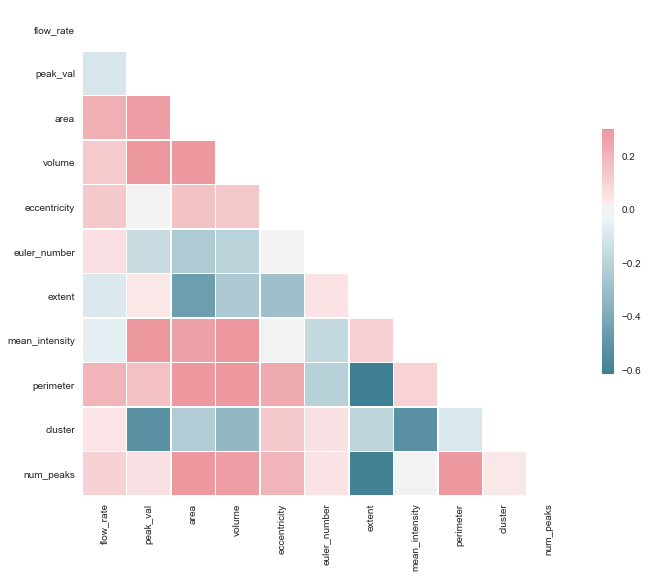

In [65]:
# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 #columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = pd.DataFrame(data=df_standardize,columns=list(samples)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

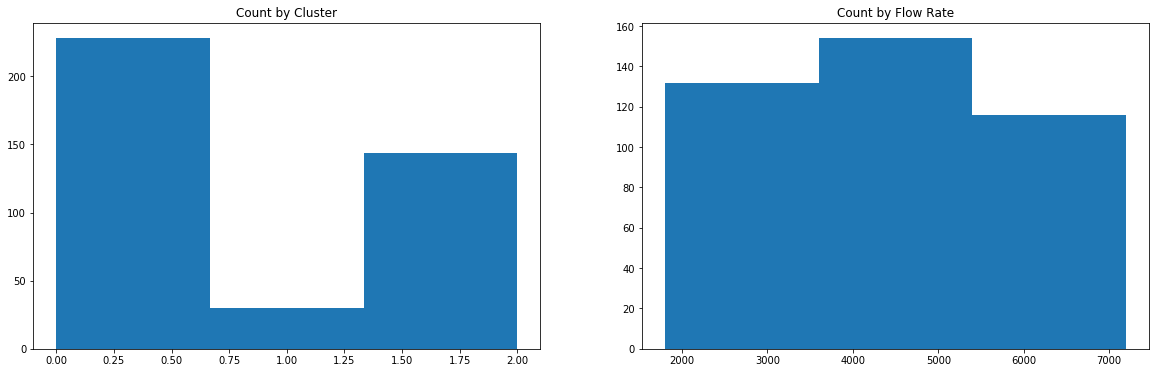

In [35]:
t = data[data['flow_rate']==1800]
u = data[data['flow_rate']==3600]
v = data[data['flow_rate']==7200]

a = data[data['cluster']==0]
b = data[data['cluster']==1]
c = data[data['cluster']==2]

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Peaks by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')

plt.subplot(121)
plt.title("Num Peaks by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')'''

plt.subplot(121)
plt.title("Count by Cluster")
plt.hist(data['cluster'], bins=3)

plt.subplot(122)
plt.title("Count by Flow Rate")
plt.hist(data['flow_rate'], bins=3)

plt.show()

Num Peaks by Flow Rate: 
1800: [118, 14, 0]
3600: [132, 18, 4]
7200: [94, 18, 4]


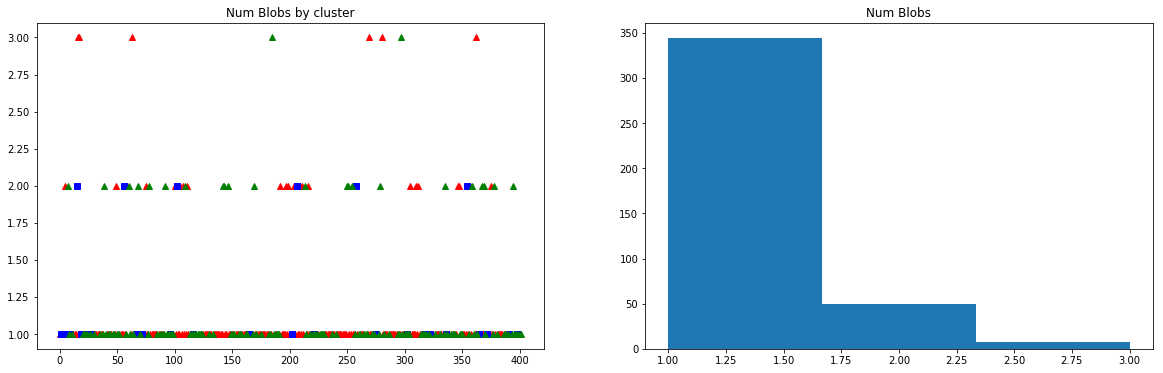

In [29]:
t = data[data['cluster']==0]['num_peaks']
u = data[data['cluster']==1]['num_peaks']
v = data[data['cluster']==2]['num_peaks']

N = 3

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

a = data[data['flow_rate']==1800]
a = a.groupby('num_peaks').size().tolist()
a.append(0)

b = data[data['flow_rate']==3600]
b = b.groupby('num_peaks').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('num_peaks').size().tolist()

print("Num Peaks by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Blobs by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')'''

plt.subplot(121)
plt.title("Num Blobs by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.subplot(122)
plt.title("Num Blobs")
plt.hist(data['num_peaks'], bins=3)

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


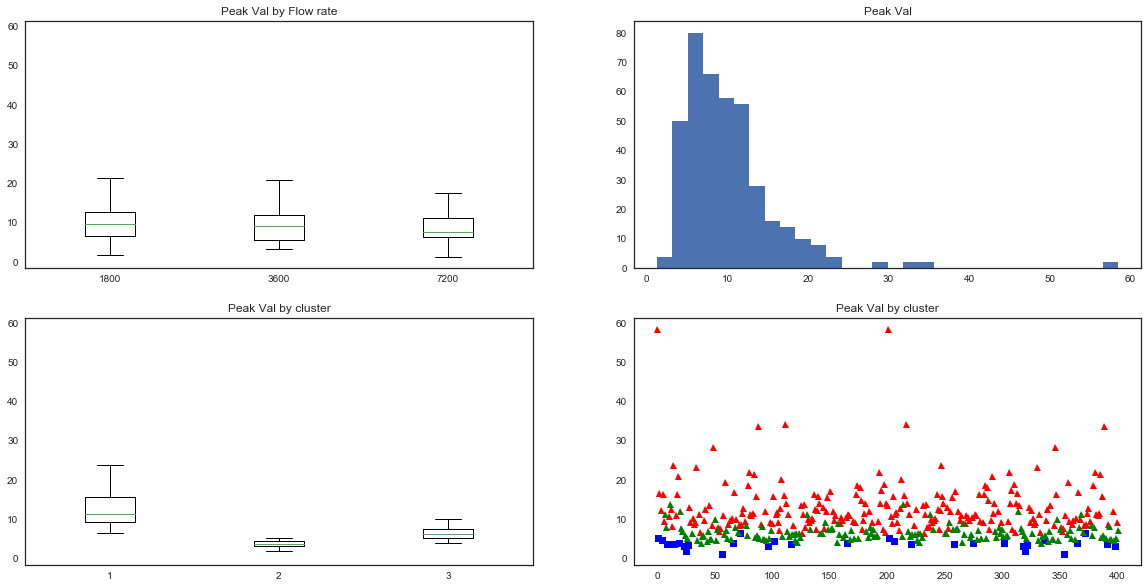

In [47]:
t = data[data['cluster']==0]['peak_val']
u = data[data['cluster']==1]['peak_val']
v = data[data['cluster']==2]['peak_val']

a = data[data['flow_rate']==1800]['peak_val']
b = data[data['flow_rate']==3600]['peak_val']
c = data[data['flow_rate']==7200]['peak_val']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Peak Val by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Peak Val")
plt.hist(data['peak_val'], bins=30)

plt.subplot(223)
plt.title("Peak Val by cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Peak Val by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


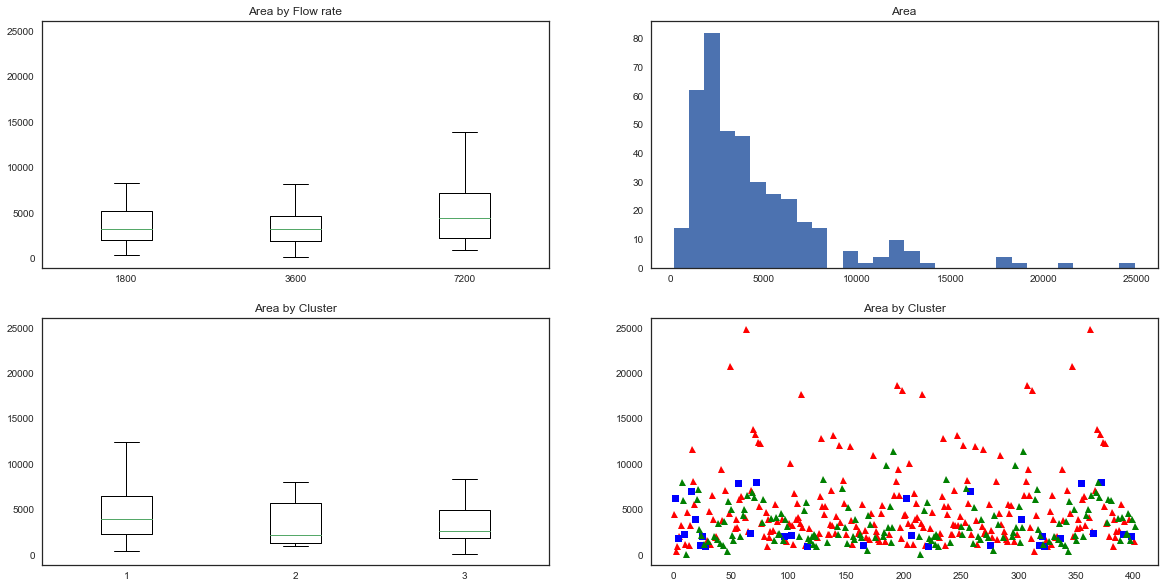

In [49]:
t = data[data['cluster']==0]['area']
u = data[data['cluster']==1]['area']
v = data[data['cluster']==2]['area']

a = data[data['flow_rate']==1800]['area']
b = data[data['flow_rate']==3600]['area']
c = data[data['flow_rate']==7200]['area']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Area by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Area")
plt.hist(data['area'], bins=30)

plt.subplot(223)
plt.title("Area by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Area by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


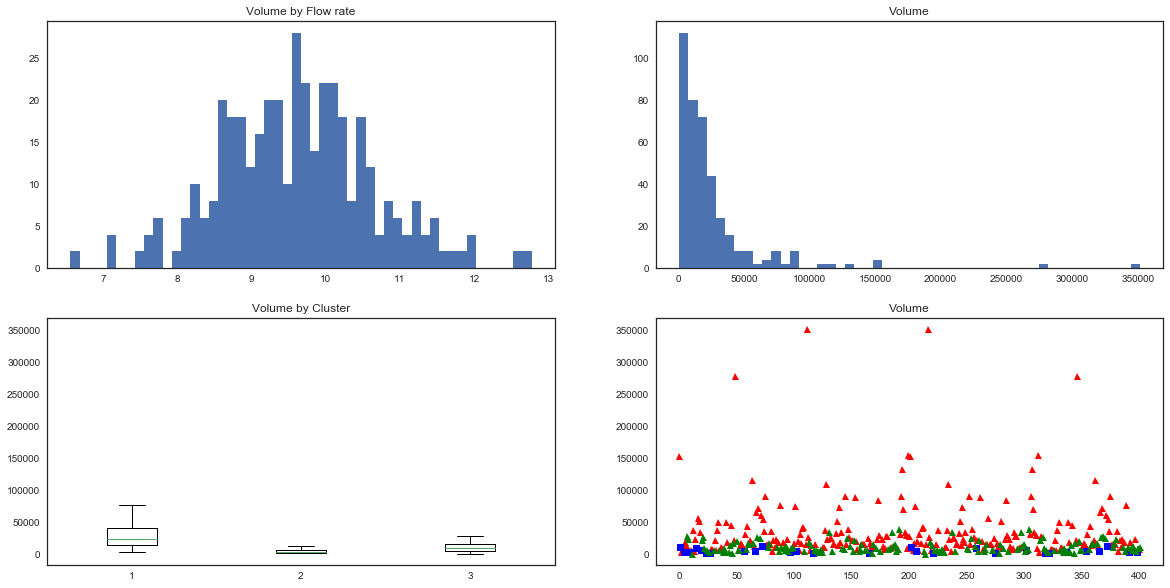

In [68]:
t = data[data['cluster']==0]['volume']
u = data[data['cluster']==1]['volume']
v = data[data['cluster']==2]['volume']

a = data[data['flow_rate']==1800]['volume']
b = data[data['flow_rate']==3600]['volume']
c = data[data['flow_rate']==7200]['volume']

log = data['volume'].apply(np.log)

plt.subplot(221)
plt.title("Volume by Flow rate")
#plt.boxplot([a,b,c], labels=['1800','3600','7200'])
plt.hist(log, bins=50)

plt.subplot(222)
plt.title("Volume")
plt.hist(data['volume'], bins=50)

plt.subplot(223)
plt.title("Volume by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Volume")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


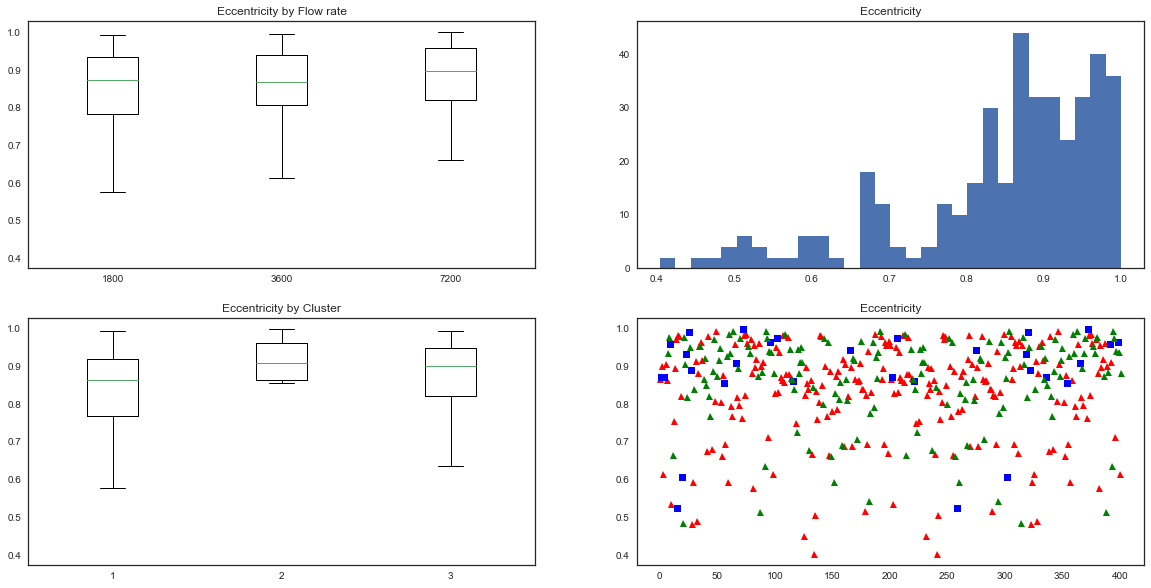

In [51]:
t = data[data['cluster']==0]['eccentricity']
u = data[data['cluster']==1]['eccentricity']
v = data[data['cluster']==2]['eccentricity']

a = data[data['flow_rate']==1800]['eccentricity']
b = data[data['flow_rate']==3600]['eccentricity']
c = data[data['flow_rate']==7200]['eccentricity']

plt.subplot(221)
plt.title("Eccentricity by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Eccentricity")
plt.hist(data['eccentricity'], bins=30)

plt.subplot(223)
plt.title("Eccentricity by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Eccentricity")
plt.plot(t, 'r^', u, 'bs', v, 'g^')


plt.show()

Euler Number by Flow Rate: 
1800: [4, 6, 122]
3600: [8, 146]
7200: [6, 110]


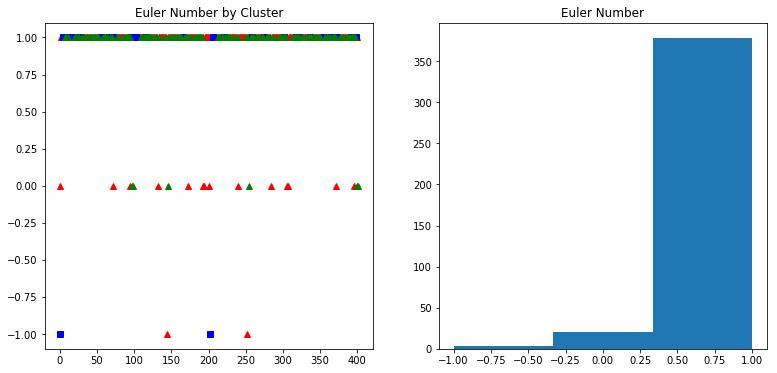

In [26]:
t = data[data['cluster']==0]['euler_number']
u = data[data['cluster']==1]['euler_number']
v = data[data['cluster']==2]['euler_number']

a = data[data['flow_rate']==1800]
a = a.groupby('euler_number').size().tolist()

b = data[data['flow_rate']==3600]
b = b.groupby('euler_number').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('euler_number').size().tolist()

print("Euler Number by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''plt.subplot(131)
plt.title("Euler Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])'''

plt.subplot(132)
plt.title("Euler Number by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.subplot(133)
plt.title("Euler Number")
plt.hist(data['euler_number'], bins=3)

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


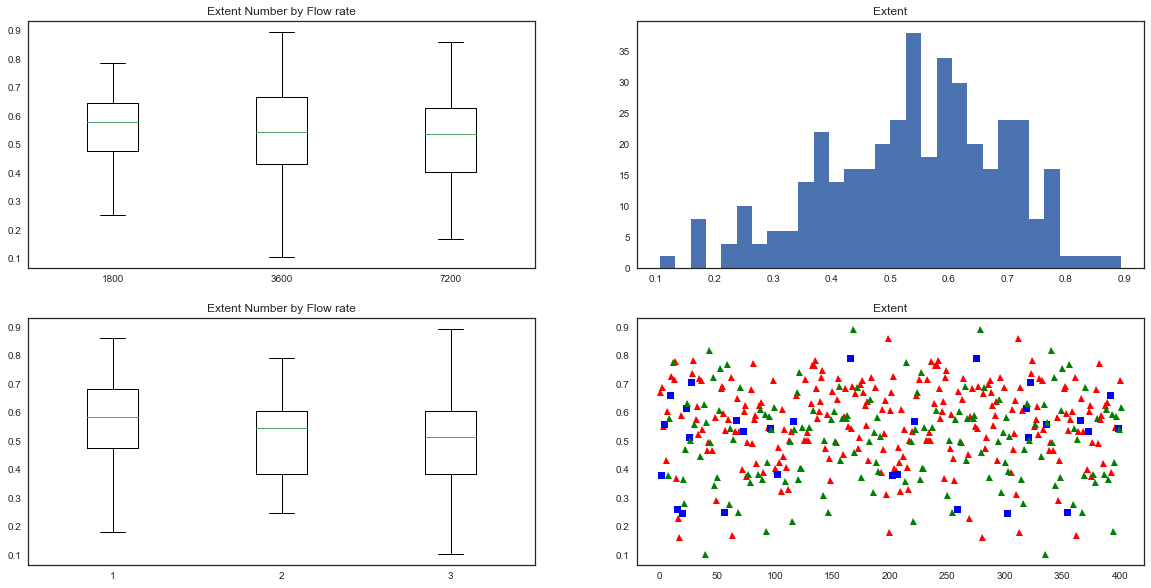

In [52]:
t = data[data['cluster']==0]['extent']
u = data[data['cluster']==1]['extent']
v = data[data['cluster']==2]['extent']

a = data[data['flow_rate']==1800]['extent']
b = data[data['flow_rate']==3600]['extent']
c = data[data['flow_rate']==7200]['extent']

plt.subplot(221)
plt.title("Extent Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Extent")
plt.hist(data['extent'], bins=30)

plt.subplot(223)
plt.title("Extent Number by Flow rate")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Extent")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


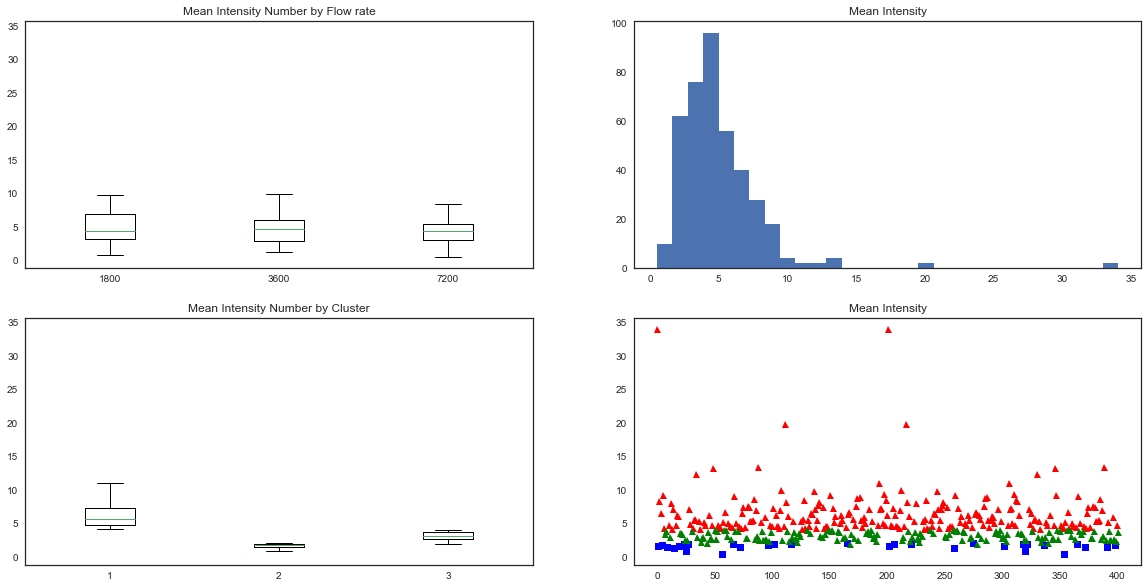

In [66]:
t = data[data['cluster']==0]['mean_intensity']
u = data[data['cluster']==1]['mean_intensity']
v = data[data['cluster']==2]['mean_intensity']

a = data[data['flow_rate']==1800]['mean_intensity']
b = data[data['flow_rate']==3600]['mean_intensity']
c = data[data['flow_rate']==7200]['mean_intensity']

plt.subplot(221)
plt.title("Mean Intensity Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Mean Intensity")
plt.hist(data['mean_intensity'], bins=30)

plt.subplot(223)
plt.title("Mean Intensity Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Mean Intensity")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


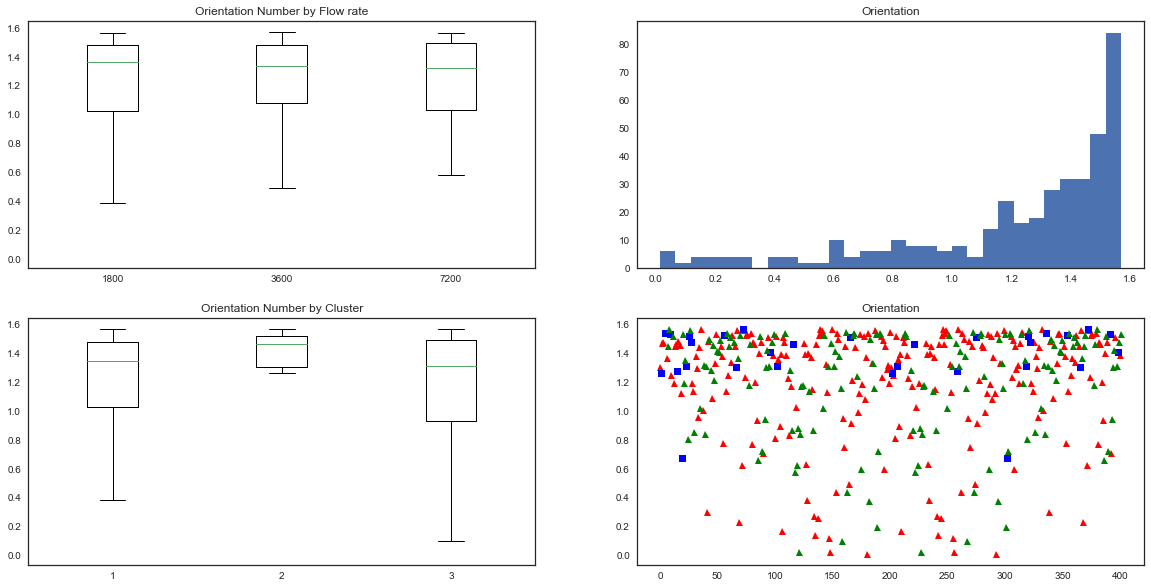

In [54]:
t = pd.DataFrame.abs(data[data['cluster']==0]['orientation'])
u = pd.DataFrame.abs(data[data['cluster']==1]['orientation'])
v = pd.DataFrame.abs(data[data['cluster']==2]['orientation'])

a = pd.DataFrame.abs(data[data['flow_rate']==1800]['orientation'])
b = pd.DataFrame.abs(data[data['flow_rate']==3600]['orientation'])
c = pd.DataFrame.abs(data[data['flow_rate']==7200]['orientation'])

plt.subplot(221)
plt.title("Orientation Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Orientation")
plt.hist(pd.DataFrame.abs(data['orientation']), bins=30)

plt.subplot(223)
plt.title("Orientation Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Orientation")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


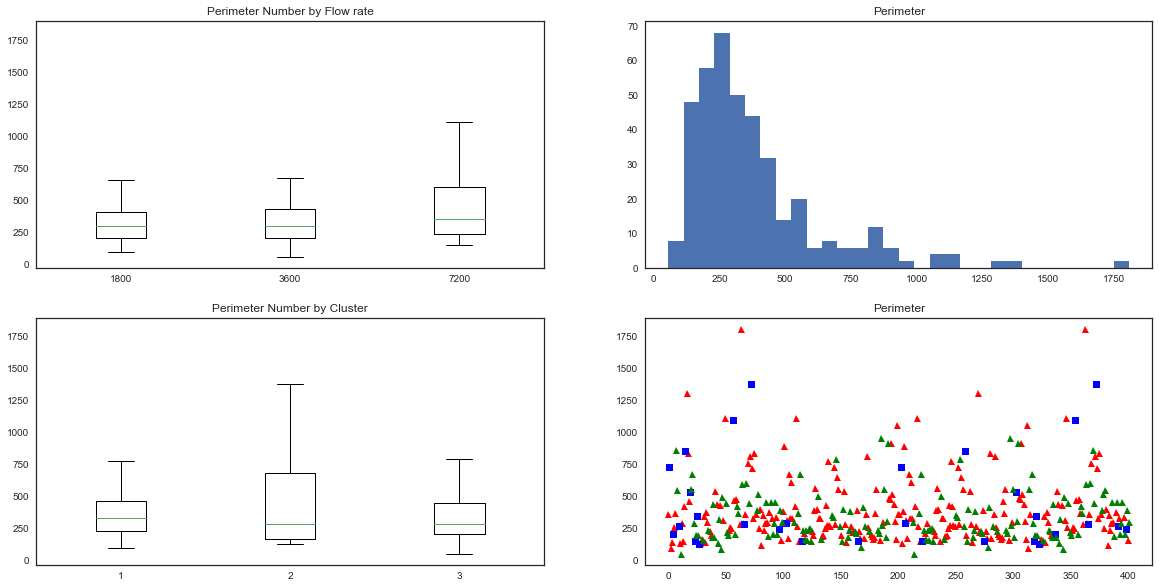

In [55]:
t = data[data['cluster']==0]['perimeter']
u = data[data['cluster']==1]['perimeter']
v = data[data['cluster']==2]['perimeter']

a = data[data['flow_rate']==1800]['perimeter']
b = data[data['flow_rate']==3600]['perimeter']
c = data[data['flow_rate']==7200]['perimeter']

plt.subplot(221)
plt.title("Perimeter Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Perimeter")
plt.hist(data['perimeter'], bins=30)

plt.subplot(223)
plt.title("Perimeter Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Perimeter")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

In [89]:
#moments = data['moments'].as_matrix()
#print(moments)

for row in data['inertia_tensor']:
    print(row)
    #moments.append()

[[ 794.11616119 1530.44545777]
 [1530.44545777 4104.84340541]]
[[ 149.43824472 -217.11304319]
 [-217.11304319 3938.09723548]]
[[2.02879511e+01 5.57794988e+01]
 [5.57794988e+01 4.09484361e+04]]
[[ 230.61349172 -321.9956515 ]
 [-321.9956515  1242.21451777]]
[[164.49377851 132.92693112]
 [132.92693112 741.39039531]]
[[115.20215761 -18.61864758]
 [-18.61864758 665.99017433]]
[[ 175.37456219 -236.95081897]
 [-236.95081897 2190.0576952 ]]
[[216.68422529  91.61993795]
 [ 91.61993795 314.80188189]]
[[234.45915274  -8.48413164]
 [ -8.48413164 176.219118  ]]
[[ 650.68892314 1140.5592428 ]
 [1140.5592428  4654.69100034]]
[[ 1907.54834142 -1529.28162602]
 [-1529.28162602  2252.44068441]]
[[ 135.28370362 -122.912562  ]
 [-122.912562    555.11731295]]
[[191.88528547   4.72499135]
 [  4.72499135 239.37221357]]
[[1993.99030592   44.18331113]
 [  44.18331113  421.95972679]]
[[ 348.75708931 -217.50710732]
 [-217.50710732  343.53054315]]
[[ 686.71000425  338.01664622]
 [ 338.01664622 2571.80037219]]
[[16

[[  31.85684096  -13.92068609]
 [ -13.92068609 1271.43461689]]
[[ 92.35607922 -34.59954753]
 [-34.59954753 260.21368117]]
[[275.69940045  79.13291678]
 [ 79.13291678 143.39161697]]
[[ 74.27075822  26.44868066]
 [ 26.44868066 283.02734394]]
[[ 222.11597891  354.20156308]
 [ 354.20156308 1377.25451785]]
[[492.97190935 264.73517411]
 [264.73517411 520.95824261]]
[[1965.46733704  678.50183205]
 [ 678.50183205 1515.77465337]]
[[120.7289145  -22.59136308]
 [-22.59136308 203.31493568]]
[[ 512.6377684  -356.24253248]
 [-356.24253248 3749.18903254]]
[[ 108.72480034  -28.99234472]
 [ -28.99234472 1299.234908  ]]
[[216.68422529 -91.61993795]
 [-91.61993795 314.80188189]]
[[275.22968971 -96.30791893]
 [-96.30791893 572.74530614]]
[[ 518.34170285 -370.60031241]
 [-370.60031241  427.78982817]]
[[ 4.65779938e+01 -3.92775015e-01]
 [-3.92775015e-01  6.73980784e+02]]
[[  724.08585171 -1588.090719  ]
 [-1588.090719   18772.50559986]]
[[133.19284636 -16.98768423]
 [-16.98768423 745.98576791]]
[[105.946930

[[13.9300168   0.52264592]
 [ 0.52264592 24.91555263]]
[[ 98.23504496  11.81111861]
 [ 11.81111861 330.38123176]]
[[ 301.57312913 -115.9663349 ]
 [-115.9663349   553.84844406]]
[[ 62.78273185 -64.04799804]
 [-64.04799804 192.68563962]]
[[1376.20149698  186.98486249]
 [ 186.98486249  838.60431051]]
[[211.08138054 -16.09575146]
 [-16.09575146 371.36072698]]
[[141.30576535  82.76151446]
 [ 82.76151446 164.61720516]]
[[301.57312913 115.9663349 ]
 [115.9663349  553.84844406]]
[[ 31.95682519 -13.69901828]
 [-13.69901828 282.68046894]]
[[ 292.97894613 -278.03612482]
 [-278.03612482  406.87915748]]
[[ 282.51903568   60.98162095]
 [  60.98162095 1944.07713525]]
[[197.08186015  47.74324053]
 [ 47.74324053 733.06360416]]
[[ 75.29410361  93.13155288]
 [ 93.13155288 825.40280598]]
[[388.86804988 102.91215484]
 [102.91215484 573.81573457]]
[[ 274.56137045 -758.89667987]
 [-758.89667987 6433.81023182]]
[[ 217.30535381  -84.86026968]
 [ -84.86026968 1122.39104635]]
[[  41.86826686   27.90681805]
 [  2

### Cluster sizes

In [154]:
print(len(data[data['cluster']==0]))
print(len(data[data['cluster']==1]))
print(len(data[data['cluster']==2]))

228
30
144


### Comparison of Manifold Algorithms

Source: http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

In [46]:
X, color = datasets.samples_generator.make_s_curve(1000, random_state=0)

In [155]:
n_neighbors = 30
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (len(points), n_neighbors), fontsize=14)

X = points
color = cluster_indices

''' ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72) '''

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca',n_iter=5000, random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

TypeError: 'module' object is not callable

<Figure size 1080x576 with 0 Axes>